## **Combining Data for use in Tableau**

We'd like to create an interactive dashboard for tableau, but to do that, we'll need to combine our data and add some new columns. Some features we'll need to add to the data include:
* `date_announcement_normalized` - an ordinal column for the date that can be used to align states based on their closing/reopening announcement date. 0 is set as noon on the announcement date and the numbers are +/- the hours in relation to that moment
* `is_reopen` - a boolean column that will say whether the row is from the state's opening or closing phase. Will do this by applying a True/False to all reopening or closing dataframes before doing a union.

In [120]:
import os
import csv
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import matplotlib.style as style
import matplotlib.pyplot as plt

In [72]:
mi_reopen = pd.read_csv('./data/sentiment_data/MI_reopen_sentiment.csv')
oh_reopen = pd.read_csv('./data/sentiment_data/OH_reopen_sentiment.csv')
fl_reopen = pd.read_csv('./data/sentiment_data/FL_reopen_sentiment.csv')
tx_reopen = pd.read_csv('./data/sentiment_data/TX_reopen_sentiment.csv')
ga_reopen = pd.read_csv('./data/sentiment_data/GA_reopen_sentiment.csv')
il_reopen = pd.read_csv('./data/sentiment_data/IL_reopen_sentiment.csv')
nj_reopen = pd.read_csv('./data/sentiment_data/NJ_reopen_sentiment.csv')
ny_reopen = pd.read_csv('./data/sentiment_data/NY_reopen_sentiment.csv')

mi_shutdown = pd.read_csv('./data/sentiment_data/MI_shutdown_sentiment.csv')
oh_shutdown = pd.read_csv('./data/sentiment_data/OH_shutdown_sentiment.csv')
tx_shutdown = pd.read_csv('./data/sentiment_data/TX_shutdown_sentiment.csv')
ga_shutdown = pd.read_csv('./data/sentiment_data/GA_shutdown_sentiment.csv')
il_shutdown = pd.read_csv('./data/sentiment_data/IL_shutdown_sentiment.csv')
nj_shutdown = pd.read_csv('./data/sentiment_data/NJ_shutdown_sentiment.csv')
ny_shutdown = pd.read_csv('./data/sentiment_data/NY_shutdown_sentiment.csv')
fl_shutdown = pd.read_csv('./data/sentiment_data/FL_shutdown_sentiment.csv')

In [39]:
def rename_date_col(rel_path='./data/sentiment_data'):
    # WARNING: IF YOU USED OLD VERSIONS OF THE NOTEBOOK, THIS MAY END UP LABELING
    # TWO COLUMNS AS DATE, YOU'LL HAVE TO MANUALLY CLEAN THE DATA. NEED TO PATCH
    # THIS IN A LATER VERSION
    
    # Iterate through all files in folder
    filenames = [filename for filename in os.listdir(rel_path) if filename.endswith('csv')]
    
    # open the file and rename the column, then save it as new csv
    for filename in filenames:
        data = pd.read_csv(f'./data/sentiment_data/{filename}')
        data.rename(columns={'formatted_date' : 'date'}).to_csv(f'./data/sentiment_data/{filename}', index=False)

In [62]:
def reorder_cols(rel_path='./data/sentiment_data'):
    filenames = [filename for filename in os.listdir(rel_path) if filename.endswith('csv')]
    for filename in filenames:
        data = pd.read_csv(f'{rel_path}/{filename}')
        data[column_order].to_csv(f'{rel_path}/ordered/{filename.split(".")[0]}_ordered.csv', index=False)

In [41]:
rename_date_col()

In [86]:
reorder_cols()

In [59]:
def combine_and_add_cols(rel_path='./data/sentiment_data'):
    '''
    This function combines and adds columns to the csvs that
    contain sentiment analysis data. Specifically, this function
    adds the following features:
    
    date_ord: creates an ordinal value from the date column
    
    -----------------------
    Parameters:
    
    rel_path : str, the path where all of your csvs are stored
    '''    
    # Getting all of a state's filenames
    filenames = [filename for filename in os.listdir(rel_path) if filename.endswith('.csv')]
    
    # Create new df so the final df doesn't keep appending if you need to run again
    # First, we'll need to get the headers - thanks Tyler on SO for this
    # https://stackoverflow.com/questions/24962908/how-can-i-read-only-the-header-column-of-a-csv-file-using-python
#     with open(f'{rel_path}/{filenames[0]}', 'r') as f:
#         reader = csv.DictReader(f)
#         fieldnames = reader.fieldnames

#     # Write a clean df
#     pd.DataFrame(columns=fieldnames + ['']).to_csv(f'{rel_path}/combined/all_states_and_dates_sentiment.csv', index=False) # THIS DIDNT" NEED TO BE A VARIABLE ++++ REMOVE WHEN DONE
    
    # We'll need this dict for later, the values are organized as [shutdown_date_announced, reopening_date]
    timeline_dict = {
        'FL': ['2020-04-01', '2020-04-29'],
        'TX': ['2020-03-31', '2020-05-18'],
        'NJ': ['2020-03-16', '2020-06-09'],
        'NY': ['2020-03-22', '2020-06-13'],
        'IL': ['2020-03-20', '2020-05-29'],
        'GA': ['2020-04-02', '2020-06-01'],
        'OH': ['2020-03-22', '2020-05-12'],
        'MI': ['2020-03-23', '2020-06-01']
    }
        
    # Main combination loop
    for filename in filenames:
        df = pd.read_csv(f'{rel_path}/{filename}')
        
        #-----------IS REOPEN-------------
        '''
        We want to add a column that tells us if the row is 
        from reopening or shutdown data, we'll do this by
        referencing the filenames since that data is included there
        '''
        
        if filename.split('_')[1] == 'shutdown':
            df['is_reopen'] = False
            is_reopen = False # Setting this for later use
        else:
            df['is_reopen'] = True
            is_reopen = True # Setting this for later use
            
        
        #--------ORDINAL NORMALIZATION-----------
        '''
        The following code will set the shutdown/reopening 
        date as 0, so we can align states on a graph based on this date.
        '''
        
        # converting date to datetime
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

        # setting date as index
        df.set_index('date', inplace=True, drop=False)
        
        # State name pulled from filename
        state_name = filename.split('_')[0]
        
        announce_date = timeline_dict[state_name][is_reopen]
        
        # Setting the announcement day and hour (since not every dataset has noon, 
        # we're using the last tweet from the announcement day as our midpoint
        announcement_day_hour = df[f'{announce_date}']['date'][len(df[announce_date])//2] # this will pick the middle entry from the announcement day

        # Take the time delta in seconds divided by 60 ** 2 to get nubmer of hours
        df['date_announcement_normalized'] = df.apply(lambda x: (x['date'] - announcement_day_hour).total_seconds() // 60 ** 2, axis=1)

            
        #----------WRITE TO FINAL DF--------
        
        if filename == filenames[0]:
            # Write to final df
            df.to_csv(f'{rel_path}/combined/all_states_and_dates_sentiment.csv', index=False)
        else:
            # Append to final df
            df.to_csv(f'{rel_path}/combined/all_states_and_dates_sentiment.csv', index=False, mode='a', header=False)

In [87]:
combine_and_add_cols('./data/sentiment_data/ordered')

## Looking at some summary statistics for our full dataset
This is the first time we have it all together, so let's check it out!


In [92]:
df = pd.read_csv('./data/sentiment_data/ordered/combined/all_states_and_dates_sentiment.csv')

In [124]:
df[['neg_score', 'neu_score', 'pos_score', 'compound_score']].describe()

,neg_score,neu_score,pos_score,compound_score
count,1.278205e+06,1.278205e+06,1.278205e+06,1.278205e+06
mean,8.214448e-02,7.929372e-01,1.249187e-01,1.209701e-01
std,1.166759e-01,1.631804e-01,1.397595e-01,5.109693e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,-9.999000e-01
25%,0.000000e+00,6.860000e-01,0.000000e+00,-2.263000e-01
50%,0.000000e+00,8.000000e-01,9.400000e-02,0.000000e+00
75%,1.390000e-01,9.280000e-01,2.060000e-01,5.574000e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,9.999000e-01


The **average compound score across all of the states observed was ~.12**, which is just slightly positive!

In [95]:
group = df.groupby(['state', 'is_reopen']).mean()['compound_score'] # Grouping by state and whether the state is in shutdown/reopening phase

In [99]:
avg_shutdown = [group[state][0] for state in df.state.unique()] # Create list of each state's avg sentiment during shutdown

In [100]:
avg_reopen = [group[state][1] for state in df.state.unique()] # Create list of each state's avg sentiment during reopening

In [112]:
baseline_sentiment = pd.DataFrame(index=df.state.unique()) # New df with states as indicies

In [113]:
baseline_sentiment['Average Sentiment Around Shutdown'] = avg_shutdown

In [114]:
baseline_sentiment['Average Sentiment Around Reopening'] = avg_reopen

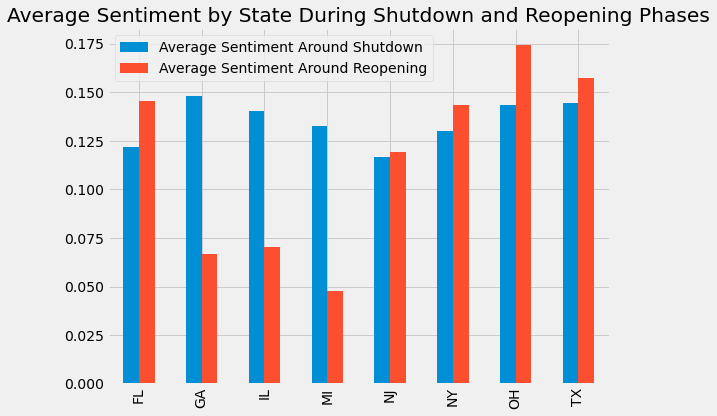

In [121]:
style.use("fivethirtyeight")
baseline_sentiment.plot(kind='bar',
                       figsize=(8, 6),
                       title='Average Sentiment by State During Shutdown and Reopening Phases',
                       legend=['Average Sentiment during Shutdown'])
plt.tight_layout();

We see that the average compound sentiment in Georgia, Illinois, and Michigan was **much lower during the reopening phase than it was during the shutdown phase**. In general, **all states except Michigan maintained a positive average compound sentiment**. Michigan's average sentiment during reopening dipped into neutral territory just barely.

## What's next?

We've got all of our data, we're going to visualize it all in Tableau, so we've got some conclusions to make!